# Step 2: Make prediction with TensorRT graph.

Run this notebook on Jetson Nano.
**For more detail, checkout [How to run TensorFlow Object Detection model on Jetson Nano](https://www.dlology.com/blog/how-to-run-tensorflow-object-detection-model-on-jetson-nano/) | DLology Blog**

In [12]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import numpy as np
import cv2
from IPython.display import Image as DisplayImage

Input and output nodes names for TensorFlow object detection API models.

In [2]:
input_names = ['image_tensor']
IMAGE_PATH = "./data/dogs.jpg"

# The TensorRT inference graph file downloaded from Colab or your local machine.
pb_fname = "./model/trt_graph.pb"

## Load the `TensorRT` frozen graph `.pb` file
This might take a while.

In [3]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def


trt_graph = get_frozen_graph(pb_fname)

Instructions for updating:
Use tf.gfile.GFile.


## Create session and load graph

In [4]:
# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

In [5]:
tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

In [6]:
tf_input.shape.as_list()

[1, None, None, 3]

### Load and Preprocess Image

In [31]:
image = cv2.imread(IMAGE_PATH)
image = cv2.resize(image, (300, 300))

### Run network on Image

In [32]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image[None, ...]
})
boxes = boxes[0]  # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = int(num_detections[0])

### Helper functions
- Function to save a `Numpy` array as an image.
- Function to draw label on `Numpy` array image.
- Non-max suppression to remove overlapping boxes.

In [33]:
def save_image(data, fname="./data/img.png", swap_channel=True):
    if swap_channel:
        data = data[..., ::-1]
    cv2.imwrite(fname, data)

In [34]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.5, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]),
                  (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale,
                (255, 255, 255), thickness)

In [35]:
def non_max_suppression(boxes, probs=None, nms_threshold=0.3):
    """Non-max suppression

    Arguments:
        boxes {np.array} -- a Numpy list of boxes, each one are [x1, y1, x2, y2]
    Keyword arguments
        probs {np.array} -- Probabilities associated with each box. (default: {None})
        nms_threshold {float} -- Overlapping threshold 0~1. (default: {0.3})

    Returns:
        list -- A list of selected box indexes.
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
                                               np.where(overlap > nms_threshold)[0])))
    # return only the bounding boxes indexes
    return pick

### Visualize the prediction results

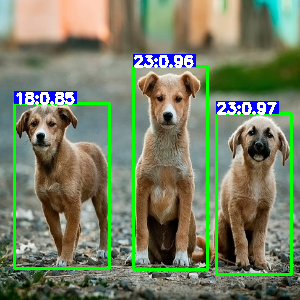

In [36]:
# Boxes unit in pixels (image coordinates).
boxes_pixels = []
for i in range(num_detections):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0],
                               image.shape[1], image.shape[0], image.shape[1]])
    box = np.round(box).astype(int)
    boxes_pixels.append(box)
boxes_pixels = np.array(boxes_pixels)

# Remove overlapping boxes with non-max suppression, return picked indexes.
pick = non_max_suppression(boxes_pixels, scores[:num_detections], 0.5)
# print(pick)


for i in pick:
    box = boxes_pixels[i]
    box = np.round(box).astype(int)
    # Draw bounding box.
    image = cv2.rectangle(
        image, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
    label = "{}:{:.2f}".format(int(classes[i]), scores[i])
    # Draw label (class index and probability).
    draw_label(image, (box[1], box[0]), label)

# Save and display the labeled image.
save_image(image[:, :, ::-1])
DisplayImage(filename="./data/img.png")

## Benchamrk
Run for `20` times and calculate the average.

In [37]:
import time
times = []
for i in range(20):
    start_time = time.time()
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image[None, ...]
    })

    delta = (time.time() - start_time)
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1/mean_delta
print('average(sec):{},fps:{}'.format(mean_delta, fps))

average(sec):0.08662562370300293,fps:11.543928427326687


## Close the session to release resources

In [ ]:
tf_sess.close()